In [57]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
pd.plotting.register_matplotlib_converters()

In [17]:
df = pd.read_json("../data/nominated_novels.json", lines=True)

In [18]:
df.ratings_count.astype(np.int64).head()

AttributeError: 'DataFrame' object has no attribute 'ratings_count'

<Axes: xlabel='n_nom', ylabel='Count'>

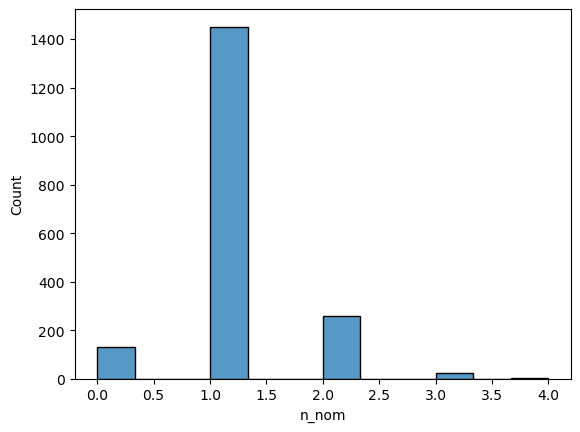

In [19]:
sns.histplot(x='n_nom', data=df)

<Axes: xlabel='n_win', ylabel='Count'>

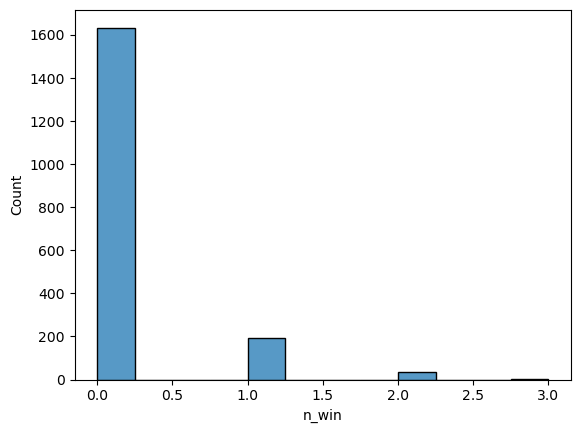

In [20]:
sns.histplot(x='n_win', data=df)

In [36]:
dfg = df.copy().assign(
).explode('genders').reset_index()

In [51]:
dfg_counts = dfg.groupby('genders').agg({'n_win': 'sum', 'n_nom': 'sum'})

<Axes: xlabel='count', ylabel='genders'>

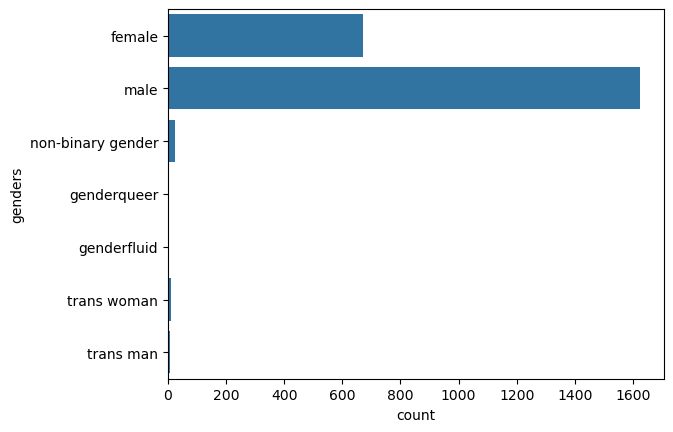

In [63]:
sns.countplot(y='genders', data=dfg)

<Axes: xlabel='n_nom', ylabel='genders'>

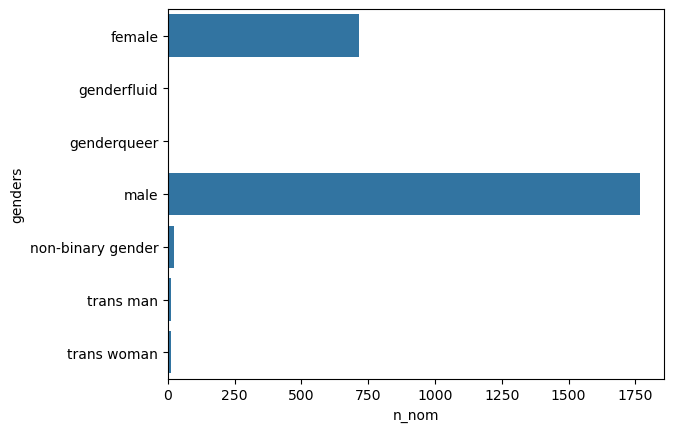

In [67]:
sns.barplot(y='genders', x='n_nom', data=dfg_counts)

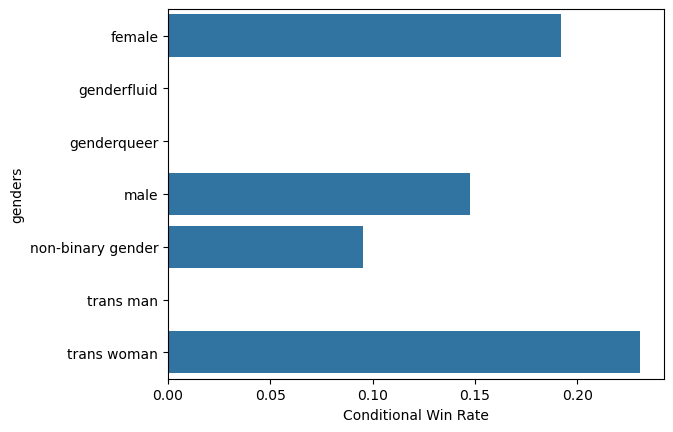

In [60]:
sns.barplot(y=dfg_counts.index, x=dfg_counts.n_win/dfg_counts.n_nom)
plt.xlabel('Conditional Win Rate')
plt.show()

<Axes: xlabel='year', ylabel='n_nom'>

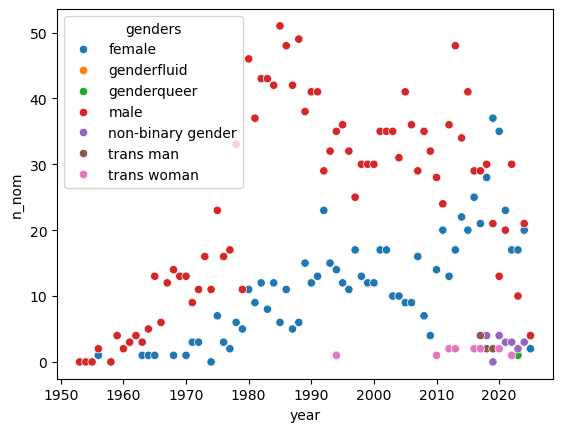

In [70]:
dfg_counts_by_year = dfg.groupby(['genders', 'year']).agg({'n_win': 'sum', 'n_nom': 'sum'}).reset_index()
sns.scatterplot(x='year', y='n_nom', data=dfg_counts_by_year, hue='genders')

<Axes: xlabel='year', ylabel='n_win'>

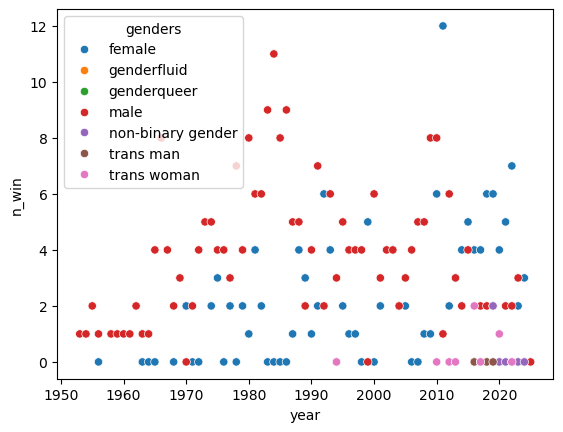

In [71]:
sns.scatterplot(x='year', y='n_win', data=dfg_counts_by_year, hue='genders')

<Axes: xlabel='n_win', ylabel='ages'>

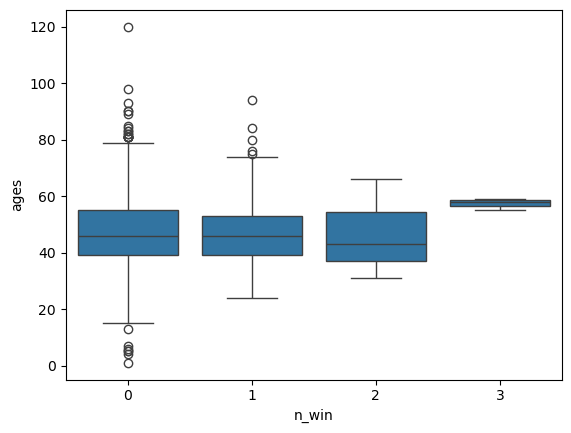

In [75]:
sns.boxplot(y='ages', x='n_win', data=df.explode('ages').reset_index())

<Axes: xlabel='n_nom', ylabel='ages'>

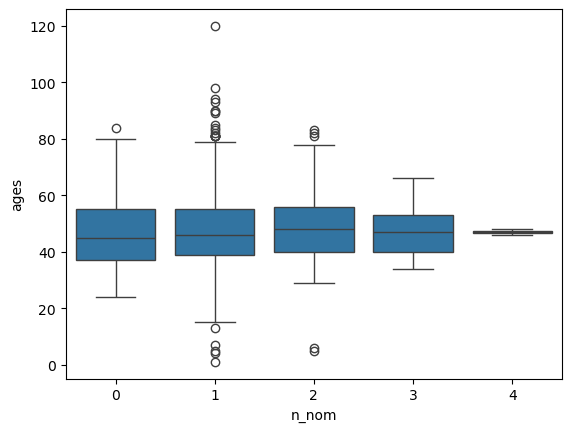

In [76]:
sns.boxplot(y='ages', x='n_nom', data=df.explode('ages').reset_index())